In [ ]:
import os
import cv2
import numpy as np

# Set dataset path (this must match your Kaggle dataset name)
data_path = '/kaggle/input/betel-leaf/Comprehensive Betel Leaf Disease Dataset for Advanced Pathology Research/Betel Leaf Dataset/Betel Leaf Dataset/Betel Leaf Dataset/Augmented_Dataset'  # <- Replace with actual dataset name

categories = sorted(os.listdir(data_path))
print("Number of classes:", categories)
noofClasses = len(categories)
print("Total number of classes:", noofClasses)
print("Importing images...")

labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

print("Label dictionary:", label_dict)
print("Categories:", categories)
print("Labels:", labels)

img_size = 124
data = []
target = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Direct grayscale

        try:
            imga = cv2.resize(img, (img_size, img_size))  # Resize

            # Z-score normalization
            mean = np.mean(imga)
            std = np.std(imga)
            imga = (imga - mean) / (std if std != 0 else 1)

            data.append(imga)
            target.append(label_dict[category])
        except Exception as e:
            print(f'Exception processing image {img_name}: {e}')

data = np.array(data)
target = np.array(target)

print("Data shape:", data.shape)
print("Target shape:", target.shape)

# Save arrays to Kaggle's writable directory
np.save("/kaggle/working/FirstStageX.npy", data)
np.save("/kaggle/working/FirstStagey.npy", target)

print(" Files saved to /kaggle/working/")

In [2]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
original_data_dir = '/kaggle/input/betel-leaf/Comprehensive Betel Leaf Disease Dataset for Advanced Pathology Research/Betel Leaf Dataset/Betel Leaf Dataset/Betel Leaf Dataset/Augmented_Dataset'
base_output_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_output_dir, 'train')
val_dir = os.path.join(base_output_dir, 'val')
test_dir = os.path.join(base_output_dir, 'test')

# Create output directories
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# Get all class names
classes = os.listdir(original_data_dir)

for cls in classes:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)

    # Split: 80% train, 10% val, 10% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.20, random_state=42)  # 20% for val+test
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.50, random_state=42)  # Split 20% into 10% val, 10% test

    for img_list, subset in zip(
        [train_imgs, val_imgs, test_imgs],
        [train_dir, val_dir, test_dir]
    ):
        subset_cls_dir = os.path.join(subset, cls)
        os.makedirs(subset_cls_dir, exist_ok=True)

        for img in img_list:
            src = os.path.join(cls_dir, img)
            dst = os.path.join(subset_cls_dir, img)
            shutil.copy(src, dst)

print("✅ Dataset successfully split into 80:10:10 (train:val:test) ratio.")

✅ Dataset successfully split into 80:10:10 (train:val:test) ratio.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Dense,
                                     Dropout, Activation, Multiply, Add, Lambda, Concatenate, Reshape)
from tensorflow.keras.optimizers import Adam

# ----------------------- CBAM BLOCK DEFINITIONS -----------------------
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    shared_dense_one = Dense(channel // ratio, activation='relu')
    shared_dense_two = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)
    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return Multiply()([input_feature, cbam_feature])

def cbam_block(input_feature):
    x = channel_attention(input_feature)
    x = spatial_attention(x)
    return x

# ----------------------- DATA PATHS AND PARAMS -----------------------
train_path = '/kaggle/working/split_data/train'
val_path = '/kaggle/working/split_data/val'
test_path = '/kaggle/working/split_data/test'

img_size = 224
batch_size = 64
epochs = 300

# ----------------------- DATA GENERATORS -----------------------
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ----------------------- BUILD MODEL -----------------------
def build_cbam_cnn(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Block 1 (kernel size 7)
    x = Conv2D(32, 7, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(32, 7, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = cbam_block(x)
    x = MaxPooling2D()(x)

    # Block 2 (kernel size 5)
    x = Conv2D(64, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(64, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = cbam_block(x)
    x = MaxPooling2D()(x)

    # Block 3 (kernel size 3)
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = cbam_block(x)
    x = MaxPooling2D()(x)

    # Block 4 (kernel size 3)
    x = Conv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = cbam_block(x)
    x = MaxPooling2D()(x)

    # Classification Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ----------------------- COMPILE & TRAIN -----------------------
model = build_cbam_cnn(input_shape=(224, 224, 3), num_classes=3)
model.summary()

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

# ----------------------- EVALUATE & SAVE -----------------------
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print(f"\n✅ Final Test Accuracy: {test_acc:.4f}")

model.save("betel_leaf_model.h5")
print("💾 Model saved as 'betel_leaf_model.h5'.")

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step
Classification Report:
              precision    recall  f1-score   support

Healthy_Leaf       0.93      1.00      0.96       540
    Leaf_Rot       0.98      0.92      0.95       135
   Leaf_Spot       0.99      0.90      0.95       344

    accuracy                           0.96      1019
   macro avg       0.97      0.94      0.95      1019
weighted avg       0.96      0.96      0.96      1019

Confusion matrix, without normalization
[[539   0   1]
 [  9 124   2]
 [ 31   2 311]]


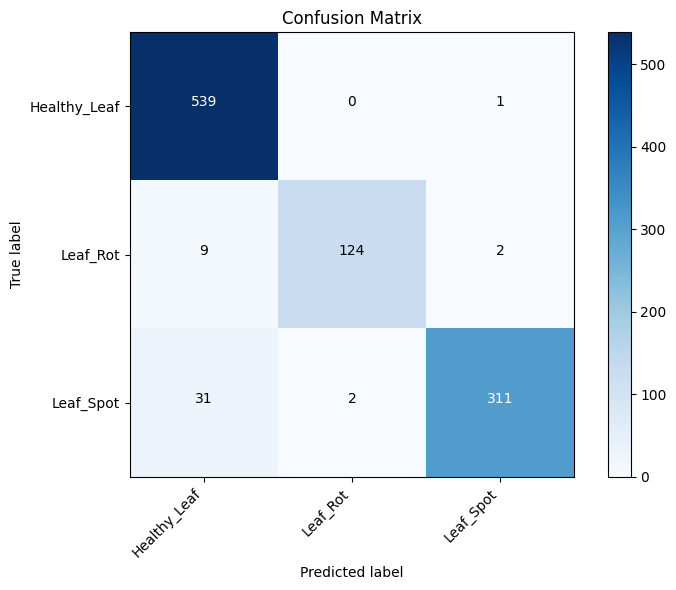

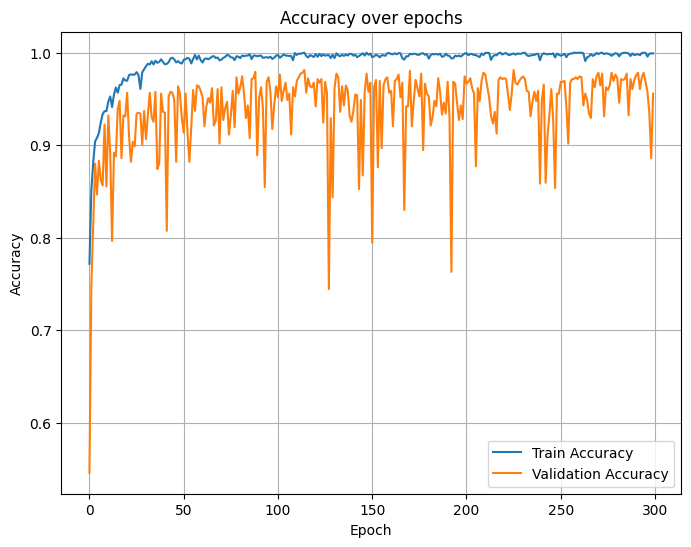

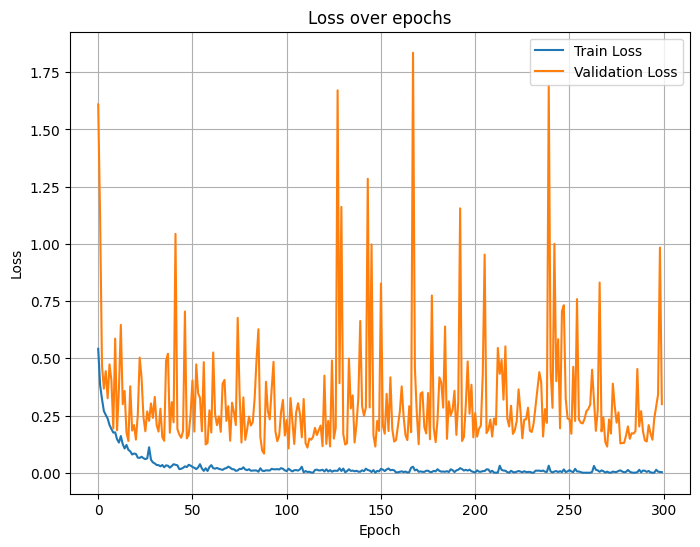

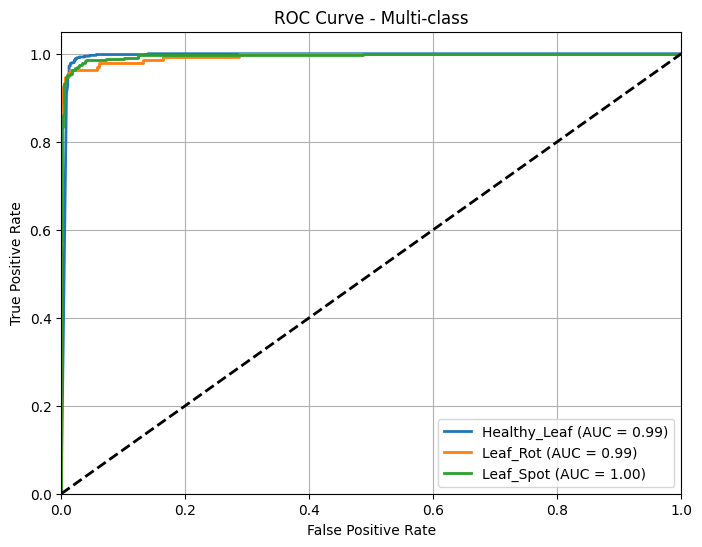

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools

# 1. Predict labels on test set
test_steps = test_data.samples // test_data.batch_size + 1
y_pred_prob = model.predict(test_data, steps=test_steps)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_data.classes

# 2. Classification Report
target_names = list(test_data.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix plot function (no normalization)
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))

    print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = 'd'  # integer format
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=600)
    plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')

# Plot Accuracy curve separately
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('accuracy_curve.png', dpi=600)
plt.show()

# Plot Loss curve separately
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('loss_curve.png', dpi=600)
plt.show()


# 5. ROC Curve for multi-class (One-vs-Rest)
# Binarize the true labels for ROC
y_true_bin = label_binarize(y_true, classes=range(len(target_names)))

plt.figure(figsize=(8,6))
for i in range(len(target_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('roc_curve.png', dpi=600)
plt.show()